\begin{align}
    \frac{\partial \rho}{\partial t} = \underbrace{D_b \frac{\partial^2 \rho}{\partial x^2}}_{\text{Diffusion}} + \underbrace{r \rho}_{\text{Exp growth}} - \underbrace{\frac{r}{K} \rho \int G(x' - x) \rho(x') \mathrm{d} x'}_{\text{Non-local competition}}
\end{align}

If the competition term is given by a Dirac delta function $G(x' - x) = \delta(x' - x)$, than the competition only occurs at in the spot $x$, not around it. We can see that in this case we gain the usual logistic growth model with local competition

\begin{align}
    \frac{\partial \rho}{\partial t} = D_b \frac{\partial^2 \rho}{\partial x^2} + r \rho - \frac{r}{K} \rho \underbrace{\int \delta(x' - x) \rho(x') \mathrm{d} x'}_{\displaystyle \int \delta(x - a) f(x) \mathrm{d} x = f(a)} = \frac{\partial^2 \rho}{\partial x^2} + r \rho - \frac{r}{K} \rho^2
\end{align}

In 2D space the equation is

\begin{align}
    \frac{\partial \rho}{\partial t} = D_b \left( \frac{\partial^2 \rho}{\partial x^2} + \frac{\partial^2 \rho}{\partial y^2} \right) + r \rho - \frac{r}{K} \rho \int G(r' - r) \rho(r') \mathrm{d} r'
\end{align}

where $r = \sqrt{x^2 + y^2}$.

In [273]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit, jit
import time
from matplotlib.ticker import FormatStrFormatter

In [173]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [115]:
@jit
def neibors(rho, i, j, m, n, dx):
    coordinates = []
    for k in range(int((i-m)),int((i+m))+1):
        for l in range(int((j-m)),int((j+m))+1):
            d = np.sqrt(((k - i)*dx)**2 + ((j - l)*dx)**2)
            if d <= m*dx:
                coordinates.append(rho[k%n,l%n])
    return np.array(coordinates)

In [116]:
@jit
def kernel(n, m):
    kernel = np.zeros((n,n))
    for k in range(int((n-1)/2 +1)-m,int((n-1)/2 +1)+m+1):
        for l in range(int((n-1)/2 +1)-m,int((n-1)/2 +1)+m+1):
            d = np.sqrt((k - int((n-1)/2))**2 + ((l - int((n-1)/2))**2))
            if d <= m:
                kernel[k%n,l%n] = 1
    return kernel

In [110]:
@jit
def fft_transform(grid):
    ft_k = np.fft.ifftshift(grid)
    ft_k = np.fft.fft2(ft_k)
    ft_k = np.fft.fftshift(ft_k)
    return ft_k

@jit
def inverse_fft_transform(grid):
    ft = np.fft.ifftshift(grid)
    ft = np.fft.ifft2(ft)
    ft = np.fft.fftshift(ft).real
    return ft

In [294]:
@jit
def solve_model(t_max, rho, size_min, size_max, n, D_b, r, k, dt_size, m, automatic_stop = True,
                print_progress = True):
    # Defining the step in space and time
    dx = (size_max - size_min)/n
    dt = dx**2 / (2*dt_size*D_b)
    # print(dt)
    # print(t_c/dt)
    # Defining space
    x = np.linspace(size_min, size_max, n)
    # Array of derivatives
    drhodt = np.zeros((n,n))
    # Defining time
    #t = np.arange(0, t_max, dt)
    
    # Array of solutions for density and concentration
    rhos = [rho]
    tot_rho = [np.sum(rho*dx), np.sum(rho*dx)]
    
    gamma = r/k
    
    krnl = kernel(n, m)
    ft_k = fft_transform(krnl)
    
    # Loop in time
    i = 0
    while i < t_max:
        # print(rho)
        if print_progress:
            if i % 10000 == 0:
                print("Still computing... step:", i)
        if automatic_stop:
            if np.abs(tot_rho[-1] - tot_rho[-2]) < 1e-10:
                break
        i += 1
        # rho[0] = rho[n-1]
        # rho[n-1] = rho[0]
        
        # Competition
        ft_rho = fft_transform(rho)
        non_local_comp = inverse_fft_transform(ft_rho*ft_k)
        competition = gamma*rho*non_local_comp*dx**2/(np.pi*m**2)
        for j in range(0,n):
            for k in range(0,n):
                # Growth
                growth = r*rho[j,k]
                # Bacterial equation
                drhodt[j,k] = D_b*((rho[(j+1)%n,k] + rho[j,(k+1)%n] - 4*rho[j,k] + rho[(j-1)%n,k] + rho[j,(k-1)%n])/dx**2) + growth

        #print(drhodt)
        rho = rho + (drhodt - competition)*dt

        #print(rhos)
        #print(rho)
        if i % 1000 == 0:
            rhos.append(rho)
            tot_rho.append(np.sum(rho*dx))
    return rhos, tot_rho, i, dx, dt, x

In [295]:
r = 1.3 # h⁻¹
k = 2

D_b = 0.005 # μm²/h
t_max = 200001#*(t_c/128)
dt_size = 128
x_max = 10
n = 101 # Must always be impar
m = 10

# Initial condition
rho = np.random.uniform(0.08, 0.08, (n,n))

print('\nReady to run simulations. Making a test before starting \n')

test = solve_model(5, rho, 0, 5, n, D_b, r, k, dt_size, 2)

print("\nTest concluded. Proceeding with simulation... \n")

# Initial condition
rho = np.random.uniform(1, 1.2, (n,n))

rhos, tot_rho, idx, dx, dt, x = solve_model(t_max, rho, 0, x_max, n, D_b, r, k, dt_size, m,
                                            automatic_stop = False)


Ready to run simulations. Making a test before starting 

Still computing... step: 0

Test concluded. Proceeding with simulation... 

Still computing... step: 0
Still computing... step: 10000
Still computing... step: 20000
Still computing... step: 30000
Still computing... step: 40000
Still computing... step: 50000
Still computing... step: 60000
Still computing... step: 70000
Still computing... step: 80000
Still computing... step: 90000
Still computing... step: 100000
Still computing... step: 110000
Still computing... step: 120000
Still computing... step: 130000
Still computing... step: 140000
Still computing... step: 150000
Still computing... step: 160000
Still computing... step: 170000
Still computing... step: 180000
Still computing... step: 190000
Still computing... step: 200000


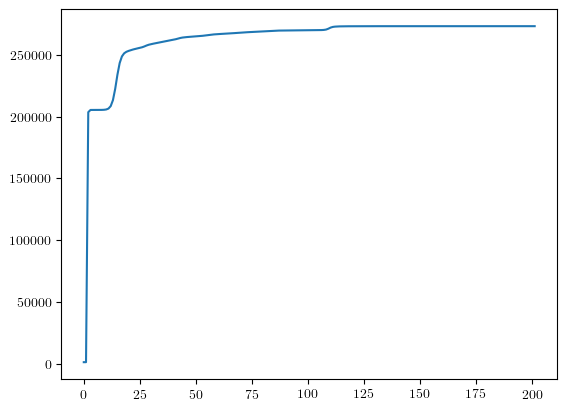

In [299]:
plt.plot(tot_rho)
plt.show()

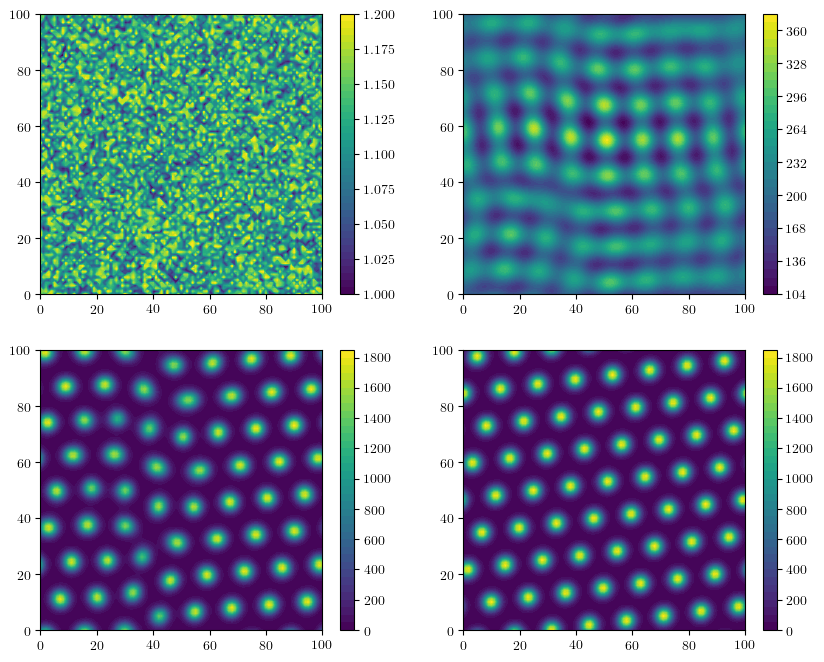

In [300]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
im_00 = ax[0,0].contourf(rhos[0], levels = 40)
im_01 = ax[0,1].contourf(rhos[10], levels = 40)
im_10 = ax[1,0].contourf(rhos[50], levels = 40)
im_11 = ax[1,1].contourf(rhos[len(rhos)-1], levels = 40)
# plt.yscale('log')
plt.colorbar(im_00, ax = ax[0,0])
plt.colorbar(im_01, ax = ax[0,1])
plt.colorbar(im_10, ax = ax[1,0])
plt.colorbar(im_11, ax = ax[1,1])
plt.show()

In [301]:
X, Y = np.meshgrid(x, x)

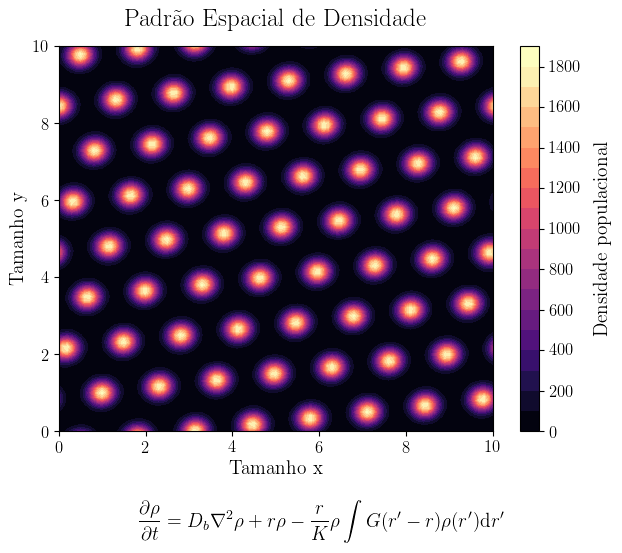

In [304]:
fig, ax = plt.subplots(figsize = (7,5))
im = ax.contourf(X, Y, rhos[-1], levels = 20, vmin = 0, vmax = 1800, cmap = 'magma')
cbar = plt.colorbar(im, ax = ax)
cbar.ax.set_ylabel(r'Densidade populacional', fontsize = 14, labelpad = 10)
cbar.ax.set_yticks([200*i for i in range(10)])
cbar.ax.set_yticklabels([200*i for i in range(10)], fontsize = 12)
plt.xlabel('Tamanho x', fontsize = 14)
plt.ylabel('Tamanho y', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Padrão Espacial de Densidade', fontsize = 18, pad = 14)
fig.text(0.5, -0.08, r"$\displaystyle \frac{\partial \rho}{\partial t} = D_b \nabla^2 \rho + r \rho - \frac{r}{K} \rho \int G(r' - r) \rho(r') \mathrm{d} r'$",
         fontsize = 14, ha = 'center')
# fig.text(0.5, -0.19, r"$\displaystyle G(r' - r) = \frac{1}{\pi r_c^2}$ se $r' - r \leq r_c$, $r = \sqrt{x^2 + y^2}$",
#          fontsize = 14, ha = 'center')
plt.savefig('Spatial_pattern_density_pt-br_with_eq.png', dpi = 300, bbox_inches = 'tight')
plt.savefig('Spatial_pattern_density_pt-br_with_eq.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [308]:
for i in tqdm(range(len(rhos))):
    if i % 2 == 0:
        fig, ax = plt.subplots(1, 2, figsize = (7,5), gridspec_kw = {'width_ratios': [8,1]})
        ax[0].contourf(X, Y, np.log10(rhos[i]), levels = 20, vmin = 0.4, vmax = 3.2, cmap = 'magma')
        # plt.clim(-0.4,3.2)
        a = np.array([[0,3.3]])
        img = plt.imshow(a, cmap = plt.get_cmap('magma', 22))
        plt.gca().set_visible(False)
        cax = plt.axes([0.8, 0.11, 0.03, 0.77])
        cbar = plt.colorbar(orientation="vertical", cax=cax, ticks = [0,0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7,3,
                                                              3.3])
        cbar.ax.set_ylabel(r'Densidade populacional', fontsize = 14, labelpad = 10)
        cbar.ax.set_yticks([0,0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7,3,
                                                              3.3])
        cbar.ax.set_yticklabels([f'{10**i:.2f}' for i in [0,0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7,3,
                                                              3.3]], fontsize = 12)
        ax[0].set_xlabel('Tamanho x', fontsize = 14)
        ax[0].set_ylabel('Tamanho y', fontsize = 14)
        ax[0].set_xticks(ax[0].get_xticks())
        ax[0].set_yticks(ax[0].get_yticks())
        ax[0].set_xticklabels(ax[0].get_xticks(), fontsize = 12)
        ax[0].set_yticklabels(ax[0].get_yticks(), fontsize = 12)
        ax[0].set_title(f'Padrão Espacial de Densidade | Tempo = {int(100*i)}', fontsize = 18, pad = 14)
        plt.savefig(f'Gifs/Spatial_patter_{i}.png', dpi = 300, bbox_inches = 'tight')
        plt.close()

100%|██████████| 201/201 [02:13<00:00,  1.50it/s]
